In [100]:
%load_ext autoreload
%autoreload 2
import numpy as np
# np.seterr(divide='ignore') # these warnings are usually harmless for this code
# np.random.seed(0)
from matplotlib import pyplot as plt
import matplotlib
import os
matplotlib.rcParams['font.size'] = 12
plt.rcParams.update({'figure.figsize':[18,6]})

import sys
import pyhsmm
import pyhsmm.basic.distributions as distributions

sys.path.append('/home/kirilman/Projects/nir/main nir')
import myutils
import sequence_generator as generator
from HMMClassifier import SignalManager
import pomegranate as pg
from pyhsmm.util.text import progprint_xrange
from pyhsmm.util.general import rle
from myutils import plot_signal_label
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


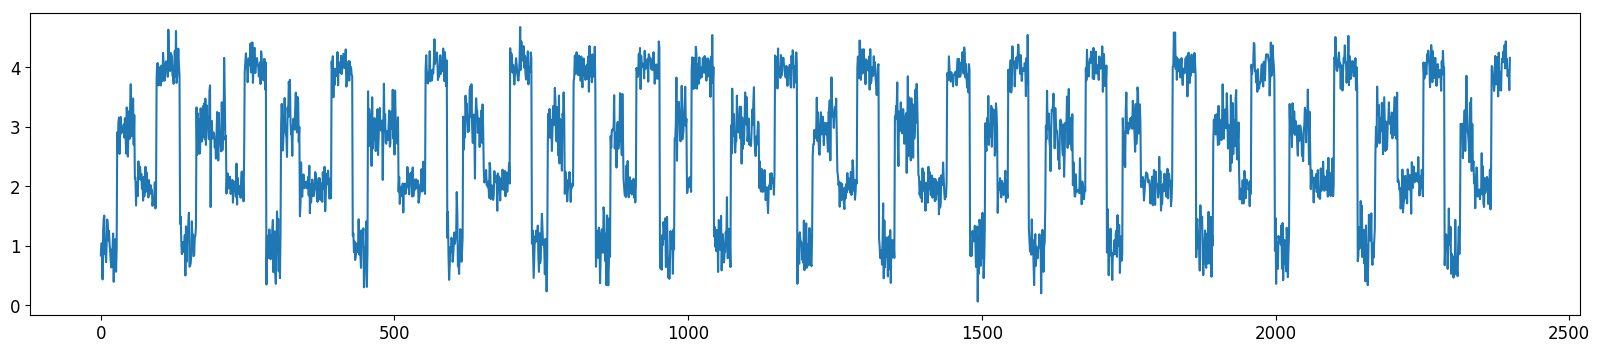

In [101]:
T = 1200
fig = plt.figure(figsize=(20,4),dpi = 100)
signal_manager = SignalManager()
signal_manager.read_paramets('config_range_ll.json')
signal = np.array(signal_manager.generators[0].sequence).reshape(-1,1)

test_signal = np.array(signal_manager.generators[1].sequence).reshape(-1,1)
plt.plot(signal[:,0])
# plt.plot(test_signal[:,0],'r--')
n_comp = 4

In [102]:
#fit model
def create_model(data, Nmax):
    obs_dim = 1
    dur_distns = []
    Nmax = 7
#     L = 5
#     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
#                     'K':L,
#                      'alphav_0':np.zeros(L)+0.1, 
#                      'alpha_mf':np.zeros(L)+0.1,
#                     }

    obs_hypparams = {'mu_0':np.zeros(obs_dim),
                    'sigma_0':np.eye(obs_dim),
                    'kappa_0':2,
                    'nu_0':obs_dim+5}
    obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]

    
    dur_hypparams = {'alpha_0':45,
                     'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':20,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':30,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':55,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    
    
    dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

    posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
            alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
            init_state_concentration=6., # pretty inconsequential
            obs_distns=obs_distns,
            dur_distns=dur_distns,
#             trans_matrix = np.eye(7,7)
    )

#     posteriormodel = pyhsmm.models.HSMM(
#             alpha=6., # На что влияет 
# #             gamma=2., # better to sample over these; see concentration-resampling.py
#             init_state_concentration=6., # pretty inconsequential
#             obs_distns=obs_distns,
#             dur_distns=dur_distns)
    
    posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
    
    fig = plt.figure(figsize=(12,10),dpi = 140)
    for idx in progprint_xrange(150):
        posteriormodel.resample_model(1)
    plt.show()
    return posteriormodel

In [103]:
hsmm = create_model(signal, n_comp)
print(hsmm.used_states)

Конструктор


/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


.........................  [  25/150,    0.92sec avg, ETA 01:55 ]
.........................  [  50/150,    0.91sec avg, ETA 01:31 ]
.........................  [  75/150,    0.92sec avg, ETA 01:09 ]
.........................  [ 100/150,    0.94sec avg, ETA 46.86 ]
.........................  [ 125/150,    0.97sec avg, ETA 24.25 ]
.........................  [ 150/150,    0.98sec avg, ETA 0.00 ]

   0.98sec avg, 02:27 total



<Figure size 1680x1400 with 0 Axes>

[4, 6, 3, 0]


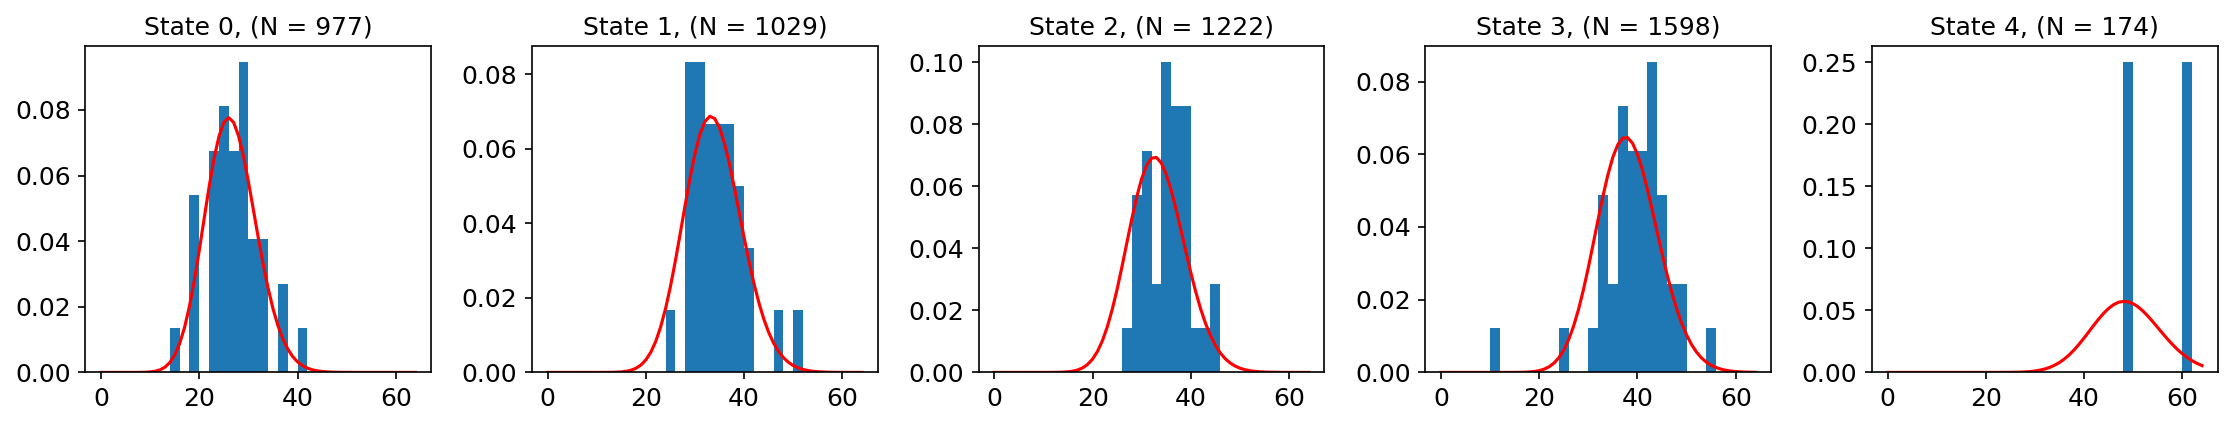

In [104]:
hsmm.plot_duration()

CPU times: user 4.06 s, sys: 3.99 ms, total: 4.06 s
Wall time: 4.06 s


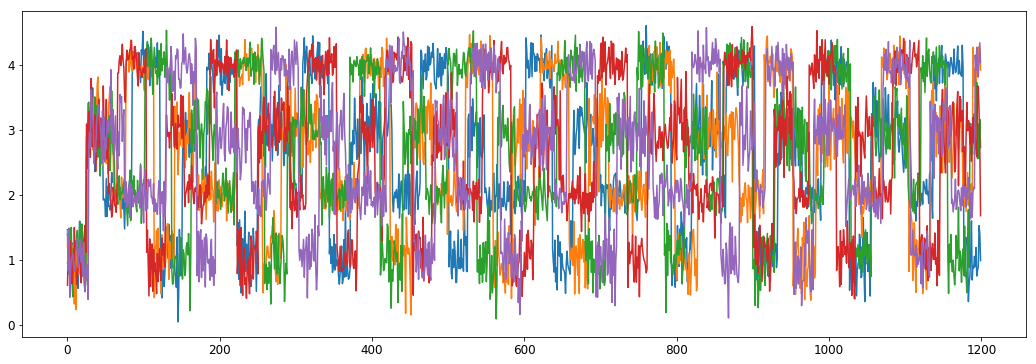

In [105]:
%%time
N = 500
x_test = np.zeros(shape=(N,T))
for i in range(500):
    x_test[i] = np.array(signal_manager.generators[0].generate_signal()[:T])
    if i%100==0:
        plt.plot(x_test[i])

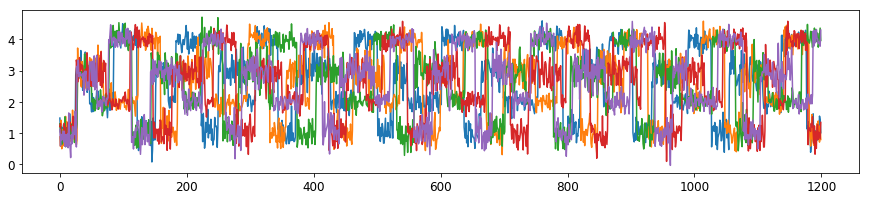

In [106]:
plt.figure(figsize=(15,3))
plt.plot(x_test[:5,:].T);

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


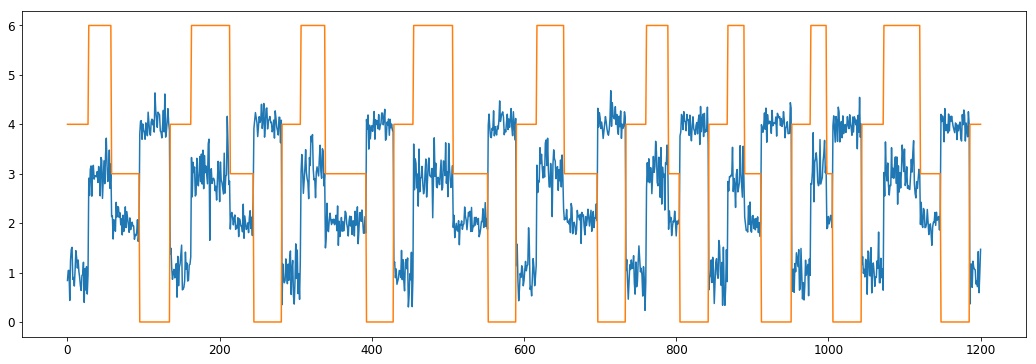

In [107]:
y_ = hsmm.predict(signal[:T].reshape(-1,1),1)
plt.plot(y_[0])
plt.plot(y_[1])

In [108]:
ll = np.array([hsmm.log_likelihood(x.reshape(-1,1)) for x in x_test])

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


204.44126460993684


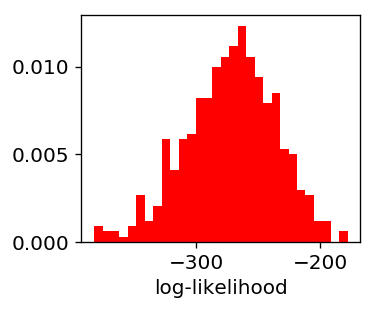

In [109]:
fig = plt.figure(figsize=(3,2.5),dpi = 120)
plt.hist(ll,bins = 30, density = True, color = 'red')
plt.xlabel('log-likelihood')
print(ll.max() - ll.min())

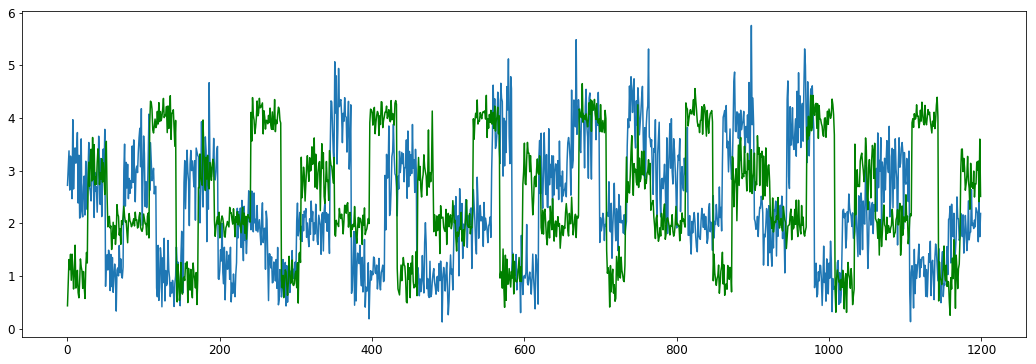

In [10]:
plt.plot(hsmm.generate(1200,keep=True)[0])
plt.plot(x_test[0],'g-')

In [88]:
q = np.array([hsmm.log_likelihood(hsmm.generate(1200,1)[0].reshape(-1,1)) for i in range(500)])

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


212.7661378000053


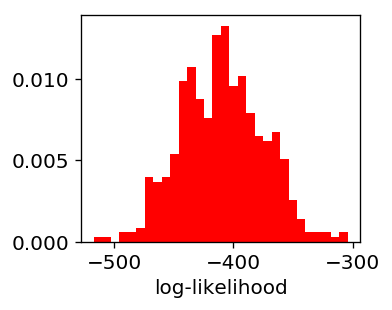

In [93]:
fig = plt.figure(figsize=(3,2.5),dpi = 120)
plt.hist(q,bins = 30, density = True, color = 'red')
plt.xlabel('log-likelihood')
print(q.max() - q.min())

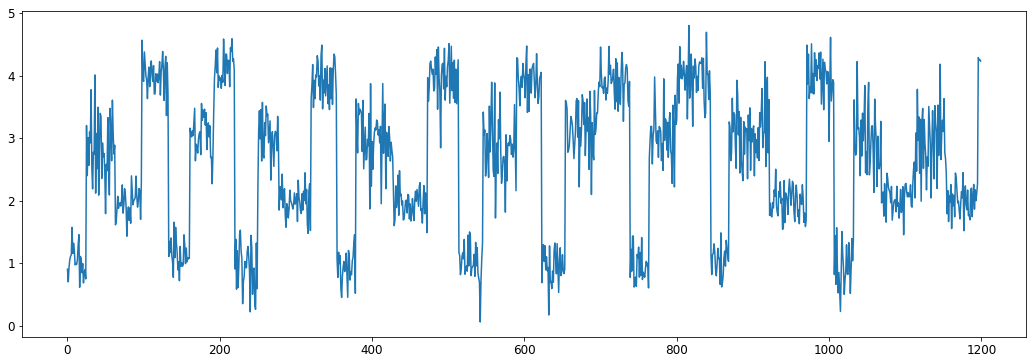

In [97]:
plt.plot(hsmm.generate(1200)[0].T)